In [1121]:
import pickle as pkl
import numpy
import pandas as pd
import autograd.numpy as np
from autograd import grad 
# from rl_functions import off_policy_per_decision_weighted_doubly_robust as WDR
from rl_functions import value_iteration
from rl_functions import learn_rewards_function
from rl_functions import learn_transition_function
from rl_functions import turn_policy_to_stochastic_policy
from autograd.misc.optimizers import adam
from sklearn.preprocessing import MinMaxScaler

In [1160]:
origin_train_set = pd.read_csv('../../data/train_scaled.csv')
origin_test_set = pd.read_csv('../../data/test_scaled.csv')

In [1122]:
train_set = pd.read_csv('../../data/train_scaled_encoded.csv')
test_set = pd.read_csv('../../data/test_scaled_encoded.csv')

In [1053]:
non_int_reward = test_set['reward']

In [1123]:
train_input = pd.read_csv('../../data/train_input_features.csv')
test_input = pd.read_csv('../../data/test_input_features.csv')

In [1129]:
del train_input['intermediate_reward']
del test_input['intermediate_reward']

## Preprocessing input features

In [1125]:
def normalize(fields, df):
    for item in fields:
        av = df[item].mean()
        std = df[item].std()
        df[item] = (df[item] - av) / std
    return df

In [1126]:
train_state_list = pkl.load(open('../../data/classify_state/train_states.pkl', 'rb'), encoding='latin1')
test_state_list = pkl.load(open('../../data/classify_state/test_states.pkl', 'rb'), encoding='latin1')

In [1127]:
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv, vaso)] = count
        count += 1

## Get test set intermediate rewards

In [1128]:
test_rewards = test_input['intermediate_reward']
train_rewards = train_input['intermediate_reward']

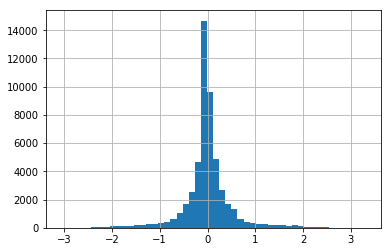

In [1199]:
pd.Series(test_rewards).hist(bins=50)

## Compute pi action

In [1205]:
# physician pi action
def get_pi(state_list, actions):
    pi = np.zeros((750, 25))
    for i, s in enumerate(state_list):
        if i == state_list.shape[0] - 1:
            break
        pi[s, int(actions[i])] += 1
    pi = pi / np.sum(pi, axis=1, keepdims=True)
    return np.nan_to_num(pi)

## Get physician actions

In [1131]:
def get_phy_actions(df):
    phy_actions = []
    vasos = df['vaso_input'].values
    ivs = df['iv_input'].values
    for i, iv in enumerate(ivs):
        phy_actions += [ action_map[ (iv, vasos[i]) ] ]
    return phy_actions

In [1132]:
train_phy_actions = get_phy_actions(train_set)
test_phy_actions = get_phy_actions(test_set)

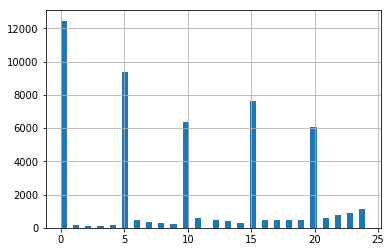

In [1175]:
pd.Series(test_phy_actions).hist(bins=50)

## Kernel based expert

In [1134]:
kernel_based = pkl.load(open('test_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')

In [1135]:
expert_k = kernel_based[:,3]
dist = kernel_based[:,4]
#num_states = kernel_based[:,-1]
#num_states = (num_states - np.mean(num_states)) / np.std(num_states)

In [1136]:
#num_bloc = ( test_input['num_bloc'] - np.mean(test_input['num_bloc']) ) / np.std(test_input['num_bloc'])

In [1139]:
test_input['dist'] = dist
#test_input['num_states'] = num_states
#test_input['num_bloc'] = num_bloc
# test_input['intercept'] = [1.] * test_input.shape[0]

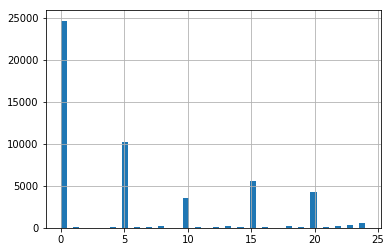

In [1140]:
% matplotlib inline
pd.Series(expert_k).hist(bins=50)

## DQN based expert

In [1141]:
expert_d = pkl.load(open('../../../code/results/with_end_state/test_agent_actions.pkl', 'rb'), encoding='latin1')

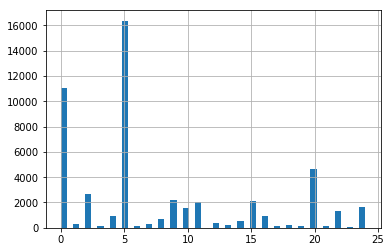

In [1142]:
% matplotlib inline
pd.Series(expert_d).hist(bins=50)

## One-hot encode expert actions

In [1143]:
def one_hot_action(action_seq):
    encoded_expert = np.zeros((action_seq.shape[0], 25))
    for i, a in enumerate(action_seq):
        encoded_expert[i, int(a)] = 1
    return encoded_expert

In [1144]:
encoded_expert_k, encoded_expert_d = one_hot_action(expert_k), one_hot_action(expert_d)

## Learn train set T, R

In [1145]:
train_bloc = train_input['num_bloc'].values

In [1146]:
trasition = np.zeros((750, 25, 750))
for i, s in enumerate(train_state_list):
    if i == train_state_list.shape[0] - 1:
        break
    if train_bloc[i + 1] == 1:
        continue
    else:
        trasition[s, train_phy_actions[i], train_state_list[i + 1]] += 1

for s in range(750):
    trasition[s] /= np.sum(trasition[s], axis=1, keepdims=True)
trasition = np.nan_to_num(trasition)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [1147]:
reward_table = np.zeros((750, 25, 750))
count = np.zeros((750, 25, 750))
for i, s in enumerate(train_state_list):
    if i == train_state_list.shape[0] - 1:
        break
    if train_bloc[i + 1] == 1:
        continue
    else:
        reward_table[s, train_phy_actions[i], train_state_list[i + 1]] += train_rewards[i]
        count[s, train_phy_actions[i], train_state_list[i + 1]] += 1
reward_table = np.nan_to_num(reward_table / count)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


## Experiment building MDP for MOE

In [186]:
t_table = np.zeros((750, 25))

In [187]:
for i, state in enumerate(train_state_list):
    t_table[state, expert1[i]] += probs[i]
    t_table[state, expert2[i]] += (1 - probs[i])

In [189]:
t_table = t_table / np.sum(t_table, axis=1, keepdims=True)

## MDP, WDR, and IS

In [1148]:
def policy_eval(MDP, prob_e, gamma=.99):
	# solve by value iteration
	(transition_matrix, reward_table) = MDP
	# print MDP
	V = np.zeros((transition_matrix.shape[0]))
	# compute V table
	while 1:
		delta = 0.
		for s in range(transition_matrix.shape[0]):
			v = np.sum(prob_e[s] * np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1))
			delta = max(delta, abs(v - V[s]))
			V[s] = v

		if delta < 0.0001:
			break
			
	# build Q_table
	Q = np.zeros((transition_matrix.shape[0], transition_matrix.shape[1]))
	for s in range(transition_matrix.shape[0]):
		Q[s] = np.sum(transition_matrix[s] * (reward_table[s] + gamma * V), axis = 1)
	return V, Q

In [1149]:
# physician pi_b
def get_pi_b(state_list, phy_actions):
    pi_b = np.zeros((750, 25))
    for i, s in enumerate(state_list):
        if i == state_list.shape[0] - 1:
            break
        pi_b[s, phy_actions[i]] += 1
    pi_b = pi_b / np.sum(pi_b, axis=1, keepdims=True)
    return pi_b

In [1150]:
train_pi_b = get_pi_b(train_state_list, train_phy_actions)
test_pi_b = np.nan_to_num(get_pi_b(test_state_list, test_phy_actions))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [1151]:
def WDR(
    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,
    pi_evaluation, pi_behavior, V = None, Q = None, num_of_states = None, num_of_actions = None ):

    num_of_trials = len( fence_posts )
    individual_trial_estimators = []
    pi_evaluation = turn_policy_to_stochastic_policy( \
        pi_evaluation, num_of_states = num_of_states, num_of_actions = num_of_actions )
    pi_behavior = turn_policy_to_stochastic_policy( \
        pi_behavior, num_of_states = num_of_states, num_of_actions = num_of_actions )
    # estimate V and Q if they are not passed as parameters
    if V is None or Q is None:
        # TODO : add part which calculate R and T from data if they are not given
        V, Q = policy_evaluation( T , R , pi_evaluation , gamma )
    # calculate the doubly robust estimator of the policy
    fence_posts_with_length_appended = fence_posts + [ len( states_sequence ) ]
    single_patient_sequences_length = [ fence_posts_with_length_appended[i+1] - \
        fence_posts_with_length_appended[i] for i in range(len(fence_posts)) ]
    length_of_longest_patient_sequence = max( single_patient_sequences_length )
    rho_array = np.nan * np.zeros( ( num_of_trials, length_of_longest_patient_sequence ) )
#    rho_array = np.ones( ( num_of_trials, length_of_longest_patient_sequence ) )
    for trial_i in range( num_of_trials ):
        rho = 1
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        t_within_trial = 0
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            if(pi_behavior[ states_sequence[ t], actions_sequence[ t]]==0):
                print(states_sequence[ t], actions_sequence[ t])
            rho *= pi_evaluation[ states_sequence[ t], actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            rho_array[ trial_i, t_within_trial ] = rho
            t_within_trial += 1
        rho_array[ trial_i, t_within_trial: ] = rho
    weights_normalization = np.sum( rho_array, axis = 0 )
    for trial_i in range( num_of_trials ):
        current_trial_estimator = 0
        rho = 1
        w = 1 / num_of_trials
        discount = 1/gamma
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        t_within_trial = 0
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            previous_w = w
            rho *= pi_evaluation[ states_sequence[ t], actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            w = rho / weights_normalization[ t_within_trial ]
            discount *= gamma
            current_trial_estimator += w * discount * rewards_sequence[ t ] - \
                discount * ( w * Q[ states_sequence[ t ], actions_sequence[ t ] ] - \
                             previous_w * V[ states_sequence[ t ] ] )
            t_within_trial += 1
        individual_trial_estimators += [ current_trial_estimator ]
    estimator = np.sum( individual_trial_estimators )

    return estimator

In [1208]:
def IS(
    states_sequence, actions_sequence, rewards_sequence, fence_posts, gamma,
    pi_evaluation, pi_behavior, num_of_states = None, num_of_actions = None ):

    num_of_trials = len( fence_posts )
    individual_trial_estimators = 0
    pi_evaluation = turn_policy_to_stochastic_policy( \
        pi_evaluation, num_of_states = num_of_states, num_of_actions = num_of_actions )
    pi_behavior = turn_policy_to_stochastic_policy( \
        pi_behavior, num_of_states = num_of_states, num_of_actions = num_of_actions )
    for trial_i in range( num_of_trials ):
        rho = 1
        discount = 1/gamma
        trial_return = 0
        if trial_i < num_of_trials - 1:
            steps_in_trial = fence_posts[ trial_i+1 ] -  fence_posts[ trial_i ]
        else:
            steps_in_trial = len( states_sequence) - fence_posts[-1]
        for t in range(
                fence_posts[ trial_i], fence_posts[ trial_i] + steps_in_trial ):
            rho *= pi_evaluation[ states_sequence[ t], actions_sequence[ t]] / \
                pi_behavior[ states_sequence[ t], actions_sequence[ t]]
            discount *= gamma
            trial_return += discount * rewards_sequence[ t ]
        individual_trial_estimators += trial_return * rho 
   
    return individual_trial_estimators / ( num_of_trials )

In [1153]:
fence_posts = []
test_bloc = test_input['num_bloc'].values
for i, idx in enumerate(test_bloc):
    if idx == 1:
        fence_posts += [ i ]

In [1154]:
def get_expert_actions(w):
    probs = get_experts_action_probs(w, test_input.values)
    moe_actions = []
    for prob in probs:
        if prob > 0.5:
            moe_actions += [0]
        else:
            moe_actions += [1]
    return moe_actions

## Classifer Training -- autograd

In [1155]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_experts_action_probs(w, f):
    p = sigmoid(np.sum(f * w, axis=1, keepdims=True))
    return p

In [1156]:
def objective(w):
    
    probs = get_experts_action_probs(w, test_input.values)
    pi_e = probs * encoded_expert_k + (1 - probs) * encoded_expert_d
    
    return IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, pi_e, test_pi_b)

In [1172]:
np.random.seed(7)
lr = 0.0001
w = np.random.normal(scale=0.3, size=(1, 5))
grad_obj = grad(objective)
objs = []

for i in range(1000):
    gradient = grad_obj(w)
    w += lr * gradient
    objs += [ objective(w) ]
    print ('step: ', i, ' objective: ', objs[-1])
    if i % 10 == 0 and i > 0:
        actions = get_expert_actions(w)
        print (np.where(np.array(actions) == 1)[0])
        print ( pd.Series(actions).value_counts() )
        print (w)

step:  0  objective:  -5.48430001071
step:  1  objective:  -5.42577053215
step:  2  objective:  -5.36713168971
step:  3  objective:  -5.30838362386
step:  4  objective:  -5.24952665514
step:  5  objective:  -5.19056129531
step:  6  objective:  -5.13148825877
step:  7  objective:  -5.07230847416
step:  8  objective:  -5.01302309613
step:  9  objective:  -4.95363351725
step:  10  objective:  -4.89414138008
[    0  1371  1604  4381  7969  8930  9063 10343 12081 13859 14528 16075
 16095 17666 19572 20855 21724 22448 22641 25205 30598 31571 32085 33935
 37377 42004 44733 47811 48671 48872 49594 49826]
0    50827
1       32
dtype: int64
[[ 0.4859389  -0.13050772 -0.00331966  0.12379688 -0.23769095]]
step:  11  objective:  -4.83454858918
step:  12  objective:  -4.77485732329
step:  13  objective:  -4.71507004736
step:  14  objective:  -4.65518952461
step:  15  objective:  -4.59521882837
step:  16  objective:  -4.53516135376
step:  17  objective:  -4.47502082921
step:  18  objective:  -4.41480

step:  71  objective:  -1.35223207331
step:  72  objective:  -1.30312358589
step:  73  objective:  -1.25455876179
step:  74  objective:  -1.20654423017
step:  75  objective:  -1.15908590782
step:  76  objective:  -1.1121889867
step:  77  objective:  -1.06585792412
step:  78  objective:  -1.02009643541
step:  79  objective:  -0.974907489123
step:  80  objective:  -0.930293304811
[    0    39   214   292   309   322   560   588   605   724   795   809
   843   877  1071  1123  1124  1135  1149  1182  1202  1310  1371  1409
  1468  1505  1513  1546  1604  1638  1658  1765  1776  1790  1834  1927
  1956  2018  2074  2183  2198  2335  2454  2580  2603  2629  2691  2799
  2956  2969  2982  3109  3171  3243  3350  3394  3560  3570  3593  3686
  3775  3836  4049  4069  4140  4153  4167  4230  4381  4408  4480  4526
  4553  4630  4763  4843  5050  5094  5095  5175  5209  5482  5620  5650
  5669  5732  5788  5939  5979  6094  6260  6330  6350  6410  6531  6676
  6850  6968  7007  7082  7091  719

step:  91  objective:  -0.477368902784
step:  92  objective:  -0.439559517808
step:  93  objective:  -0.402288734566
step:  94  objective:  -0.365549283279
step:  95  objective:  -0.329333355816
step:  96  objective:  -0.293632630056
step:  97  objective:  -0.258438294611
step:  98  objective:  -0.223741073759
step:  99  objective:  -0.189531252384
step:  100  objective:  -0.155798700774
[    0    39    65    77   135   214   292   309   322   399   560   588
   605   715   724   795   809   828   843   877   943  1071  1123  1124
  1135  1149  1182  1202  1310  1371  1409  1448  1468  1497  1505  1513
  1534  1546  1604  1638  1658  1695  1737  1765  1776  1790  1834  1927
  1956  2018  2074  2094  2111  2156  2183  2198  2227  2335  2454  2528
  2580  2603  2615  2629  2691  2715  2799  2956  2969  2982  2989  3109
  3171  3243  3263  3265  3350  3383  3394  3476  3494  3560  3570  3593
  3686  3775  3809  3836  4049  4069  4140  4153  4167  4230  4381  4408
  4480  4526  4553  4573 

step:  138  objective:  0.90156740261
step:  139  objective:  0.927807713455
step:  140  objective:  0.954299223211
[    0    39    77 ..., 50749 50761 50793]
0    49845
1     1014
dtype: int64
[[ 0.26183244 -0.05593105 -0.13544109  0.14365823 -0.24997858]]
step:  141  objective:  0.981089891449
step:  142  objective:  1.00823387666
step:  143  objective:  1.03579282749
step:  144  objective:  1.06383749909
step:  145  objective:  1.09244979409
step:  146  objective:  1.12172536408
step:  147  objective:  1.15177695961
step:  148  objective:  1.18273879193
step:  149  objective:  1.21477228065
step:  150  objective:  1.24807372793
[    0    39    77 ..., 50749 50761 50793]
0    49858
1     1001
dtype: int64
[[ 0.24802174 -0.04907467 -0.14239159  0.14593168 -0.25017466]]
step:  151  objective:  1.28288471336
step:  152  objective:  1.31950639912
step:  153  objective:  1.35831956432
step:  154  objective:  1.39981321582
step:  155  objective:  1.4446263481
step:  156  objective:  1.4936

KeyboardInterrupt: 

In [1116]:
probs = get_experts_action_probs(w, test_input.values)
pi_e = probs * encoded_expert_k + (1 - probs) * encoded_expert_d

In [1117]:
np.where( probs < 0.5 )[0].shape

(3236,)

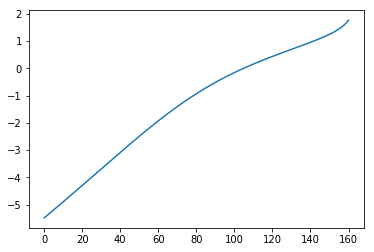

In [1196]:
import matplotlib.pyplot as plt
plt.plot(range(len(objs[:161])), objs[:161])

## IS on Kernel and DQN individually

In [1206]:
pi_k = get_pi(test_state_list, expert_k)
pi_d = get_pi(test_state_list, expert_d)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [1209]:
IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, pi_k, test_pi_b)

-2157.7660566352924

In [1210]:
IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, pi_d, test_pi_b)

-5536570.7034089863

In [1211]:
IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, test_pi_b, test_pi_b)

-0.12021211754131815

In [ ]:
test_rewards

In [1185]:
w = np.array([[ 0.22792604, -0.043015,   -0.14878969,  0.14844492, -0.25037038]])

In [1186]:
probs = get_experts_action_probs(w, test_input.values)
pi_e = probs * encoded_expert_k + (1 - probs) * encoded_expert_d

In [1213]:
pi_moe = get_pi(test_state_list, moe_actions)
IS(test_state_list, test_phy_actions, test_rewards, fence_posts, 0.99, pi_moe, test_pi_b)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


-2330.6020917428623

In [1188]:
len(np.where(probs < 0.5)[0])

1096

In [1190]:
experts = get_expert_actions(w)

In [1191]:
moe_actions = []
for i, expert in enumerate(experts):
    if expert == 0:
        moe_actions += [ expert_k[i] ]
    else:
        moe_actions += [ expert_d[i] ]

In [1198]:
pkl.dump(np.array(moe_actions), open('moe_actions.pkl', 'wb'))

In [1214]:
test_input

,num_bloc,dist,gender,age,Weight_kg
0,1.0,2.909478,0.0,0.377900,0.926956
1,2.0,2.113299,0.0,0.377900,0.926956
2,3.0,2.565387,0.0,0.377900,0.926956
3,4.0,2.410762,0.0,0.377900,0.926956
4,5.0,2.388182,0.0,0.377900,0.926956
5,6.0,2.348360,0.0,0.377900,0.926956
6,7.0,2.289565,0.0,0.377900,0.926956
7,8.0,2.232181,0.0,0.377900,0.926956
8,9.0,2.218849,0.0,0.377900,0.926956
9,10.0,2.183757,0.0,0.377900,0.926956
